New Exercise 07

# Polygon Extraction Service

This section gets all areas (polygon) with a NDVI larger than a threshold "Number".
**Input:** (dict) Coordinates of a factory
           (float) radius of the circle on the factory.
**Output:** (dict) Coordinates of the polygon + centroid


In [6]:
# Bob002 does not have the modules loaded as default, if this module is loaded, please ignore this step.
# Loading the google python api 

!pip install google-api-python-client --user

In [7]:
# Bob002 does not have the modules loaded as default, if this module is loaded, please ignore this step

# Loading the earth engine api
!pip install earthengine-api --user

In [8]:
# Import the Earth Engine module 
import ee

ModuleNotFoundError: No module named 'ee'

In [6]:
# For using the earth engine, you need to have a google account - username and password ! 
# AND you need login to Earth Engine - https://earthengine.google.com/

# If you do not have a google account, then you can use vulcano.ess2015@gmail.com passwd oceanlab This account has also been used to login to Earth Engine

# Start the authentication flow. The output is a link, when you click on it and login with your gmail account, 
# it will provide a token which you need to copy paste, below:

ee.Authenticate()

# Initialize the library.
ee.Initialize()

# Note: Multiple concurrent use of the gmail account has not been tested !

Enter verification code: 4/vgH8bx60WaJymZHmKMKEuEVZUYR5koRSNUGudYNWABtAzxujxYJsZvE

Successfully saved authorization token.


In [7]:
# Once you get "Successfully saved authorization token.", you can then proceed with the follwoing quick test ..

# Check if Mount Everest is still the highest mountain. 
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003') # loads SRTM
xy = ee.Geometry.Point([86.9250, 27.9881]) # define point
elev = dem.sample(xy, 30).first().get('elevation').getInfo() # get elevation from dem at this point
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


In [8]:
# Second Test
# Import image and plot DEM
# Import the Image function from the IPython.display module. 

from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbUrl({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

## Slight digression to a different topic (sorry)
### Using FOLIUM or Leaflet for creation on nice (slippy) interactive maps

partially from: https://python-visualization.github.io/folium/ for details on Folium maps


In [2]:
import folium # bob002 has folium installed, otherwise "!pip install folium --user"

In [ ]:
# A quick example
jub_coords = [53.1664589,8.6515011] #Define coordinates of where we want to center our map

my_map = folium.Map(location = jub_coords, zoom_start = 17) #Create the map

my_map #Display the map

In [ ]:
# Create nice markers .. with 
tooltip = 'Click me!'
folium.Marker([53.1664589,8.6515011], popup='<i>Jacobs !!</i>', tooltip=tooltip).add_to(my_map) # create marker and add to map
my_map #Display the map

In [ ]:
# Do some mapping (chloropleths) with folium
#partially adapted from https://python-visualization.github.io/folium/quickstart.html
import pandas as pd
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data' # url to data source
state_geo = f'{url}/us-states.json' # json file with the US state polygons
state_unemployment = f'{url}/US_Unemployment_Oct2012.csv' # the csv data file
state_data = pd.read_csv(state_unemployment) # read the data into pandas

m = folium.Map(location=[48, -102], zoom_start=3) # define the map region

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m) # add the various options for chloropleths 

folium.LayerControl().add_to(m)

m # display the resulting map

---
## Task 1

Create a folium map (as shown above) of your city, with a nice marker and some text (see tooltip above). Check and experiment with some of map making (display) options.

---

---
---


## Continue with Earth Engine

In [9]:
# Using FOLIUM as a basis for accessing and displaying information from Earth Engine. It creates nice map layouts for this !

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

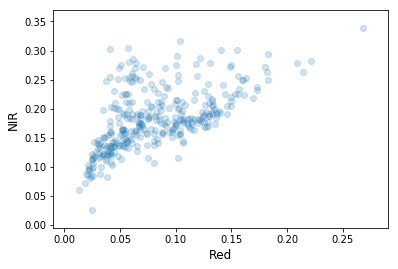

In [32]:
# Example of access to raster data and band information partially from #from https://python-visualization.github.io/folium/quickstart.html

# Import the matplotlib.pyplot module.

%matplotlib inline # places the plots inline
import matplotlib.pyplot as plt # for the graphs / plots

# Fetch a Landsat image. Please look up "Landsat Satellite Images". What are these ?

img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.

# This selects the Red Band and the Near Infra Red Bands from the data bands in "img"; scales and plots the values of the 500 pixels

samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [14]:
# Now to load satellite image data and using folium as a base

# In this step, we setup a function, so that we do not have to type the following again and again
# Have a look at the Mapdisplay function, what does it do ?

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [19]:
# Select the image and display using the function in the previous cell

image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')
mapid = image.getMapId({
    'bands': ['B4', 'B3', 'B2'], 
    'min': 0, 
    'max': 0.3})
center=[38., -122.5]
# Display the map with folium!
Mapdisplay(center, {'Median Composite':mapid},zoom_start=8)

In [20]:
# Load another image (e.g. Landsat) .. once again what are Landsat images ?
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Create an NDWI image, define visualization parameters and display. What is NDWI, maybe Normalised ...
ndwi = image.normalizedDifference(['B3', 'B5'])

# Mask the non-watery parts of the image, where NDWI < 0.4.
ndwiMasked = ndwi.updateMask(ndwi.gte(0.4))
ndwiId = ndwiMasked.getMapId({'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']})

# Display the map with folium! Cool !!
center=[38., -122.5]
Mapdisplay(center,{'NDWI masked':ndwiId})

In [21]:
# Create a circle by drawing a 20000 meter buffer around a point. What does a buffer mean ??

roi = ee.Geometry.Point([-122.4481, 37.7599]).buffer(20000)

mapRoi = image.clip(roi)
mapId = mapRoi.getMapId()

# Display map
center=[38., -122.5]
Mapdisplay(center,{'Mosaic':mapId})


---
## Task 2
Redo the above examples (image plotting, ndwi, buffer) using this Image LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913

If the above does not work, please try with 
LANDSAT/LC08/C01/T1_TOA/LC08_194028_20170116

center=[46.529, 6.74]

OR use https://code.earthengine.google.com/

---

In [22]:
# Image classification and Landcover types. Map / colorize the image to show the various classes such as croplands, etc.


cover = ee.Image('MODIS/051/MCD12Q1/2012_01_01').select('Land_Cover_Type_1') # using MODIS with land cover 

# What is or does the MODIS Satellite acquire ? Find information on this satellite. 


# Define a palette for the 18 distinct land cover classes.
igbpPalette = [
  'aec3d4', # water
  '152106', '225129', '369b47', '30eb5b', '387242', # forest
  '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
  '111149', # wetlands
  'cdb33b', # croplands
  'cc0013', # urban
  '33280d', # crop mosaic
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]

# Specify the min and max labels and the color palette matching the labels.
vizParams = {'min': 0,
             'max': 17,
             'palette': igbpPalette}
mapId = cover.getMapId(vizParams)

#Display the map with folium!
center = [38., -122.5]
Mapdisplay(center,{'Mosaic':mapId},zoom_start=8)

---

### Task 3
Create the MODIS landuse classification and visualisation for your country_of_origin. Does the image make sense, e.g. does the classification make sense such that forest region are areas that you know as forests ?

---

In [23]:
# Basic Information from One Scene
# Load image along with all the various bands. Remember one "image" might consists of various "bands" each representing a particular region of the light spectrum

image = ee.Image('LANDSAT/LC08/C01/T1/LC08_044034_20140318')

# Get information about the bands as a list.
bandNames = image.bandNames()
print('Band names: ', bandNames.getInfo()) # ee.List of band names
## Find out from the internet for Landsat which spectral regions these bands covers i.e. B3 and B4 are Red and NIR bands

Band names:  ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']


In [24]:
# Get more info on the bands such as projection, scale, time, cloud cover
# ------

# Get projection information from band 1.
b1proj = image.select('B1').projection()
print('Band 1 projection: \n', b1proj.getInfo()) # ee.Projection object

# Get scale (in meters) information from band 1.
b1scale = image.select('B1').projection().nominalScale()
print('Band 1 scale: \n', b1scale.getInfo()) # ee.Number

# Note that different bands can have different projections and scale.
b8scale = image.select('B8').projection().nominalScale()
print('Band 8 scale: \n', b8scale.getInfo()) # ee.Number

# Get a list of all metadata properties.
properties = image.propertyNames()
print('Metadata properties:', ) 
properties.getInfo() # ee.List of metadata properties

# Get a specific metadata property. Cloud cover being the most important .. WHY ???
cloudiness = image.get('CLOUD_COVER')
print('CLOUD_COVER: ')
cloudiness.getInfo() # ee.Number

from datetime import datetime as dt

# Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start'))
# We divide by 1000 because Earth Engine returns the timestamp in milisecond and Python in seconds.
tmstp = date.getInfo()['value']/1000 

print('Timestamp:', dt.utcfromtimestamp(tmstp).strftime('%Y-%m-%d %H:%M:%S'))

Band 1 projection: 
 {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [30, 0, 460785, 0, -30, 4264215]}
Band 1 scale: 
 30
Band 8 scale: 
 15
Metadata properties:
CLOUD_COVER: 
Timestamp: 2014-03-18 18:46:32


In [25]:
# Now, looking at different image types such as image composites.
# Load two 5-year Landsat 7 composites. What are 5 year composites ?

landsat1999 = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
landsat2008 = ee.Image('LANDSAT/LE7_TOA_5YEAR/2008_2012')

# Compute NDVI the hard way. What is NDVI ? Vegetation Index .. using band ratios
ndvi1999 = landsat1999.select('B4')\
                      .subtract(landsat1999.select('B3'))\
                      .divide(landsat1999.select('B4').add(landsat1999.select('B3')))

# Compute NDVI the easy way. .. using a special function ..

ndvi2008 = landsat2008.normalizedDifference(['B4', 'B3'])

#Vizualization
ndwiViz = {'min': 0, 'max': 1, 'palette': ['FF0000', '00FF00']}
Peru = ee.Geometry.Rectangle(-85, -20, -65,0) # define a region, in this case Peru

ndvi1999 = ndvi1999.clip(Peru)
ndvi2008 = ndvi2008.clip(Peru)

tiles = {
    "NDVI PERU 1999": ndvi1999.getMapId(ndwiViz), 
    "NDVI PERU 2008": ndvi2008.getMapId(ndwiViz)
}
center = [-12., -75.]
Mapdisplay(center, tiles)


---
### Task 4 
Compare (visually) the difference in Vegetation Index of 1999 / 2008 (Switch on and off the layers) in Peru (above) and if there is coverage, then your_country_of_origin.

---


In [27]:
# Load a Landsat 8 collection for a single path-row.
# from https://github.com/csaybar/EEwPython/blob/master/3_eeImageCollection.ipynb

# This define one single pass of the satellite. 

# Shows how to select / filter out a collection and compute the median of the pixels within the collection

collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filter(ee.Filter.eq('WRS_PATH', 44)).filter(ee.Filter.eq('WRS_ROW', 34)).filterDate('2014-01-01', '2015-01-01')

# Compute a median image and display.
median = collection.median()

dicc = {
    'median' : median.getMapId({'bands': ['B4', 'B3', 'B2'], 'max': 0.3})
}

# Display the results
center = [37.7726, -122.3578]
Mapdisplay(center, dicc, zoom_start= 12)

In [30]:
# Load a raw Landsat 5 ImageCollection for a single year.
# This is a different satellite ! Providing a different coverage. 
# Note that this is generally done to attain cloud free satellite image displays

# This creates an RGB Composite from three bands, see  https://github.com/vunnithan/EEwPython/blob/master/9_SpecializedAlgorithms.ipynb


collection = ee.ImageCollection('LANDSAT/LT05/C01/T1')\
               .filterDate('2010-01-01', '2010-12-31')

# Create a cloud-free composite with default parameters.
composite = ee.Algorithms.Landsat.simpleComposite(collection)

# Create a cloud-free composite with custom parameters for
# cloud score threshold and percentile.
customComposite = ee.Algorithms.Landsat.simpleComposite(
  collection=collection,
  percentile=75,
  cloudScoreRange=5
)

# Display the composites.
center=[37.7726,-122.3578]

composite_tk=composite.getMapId({'bands': ['B4', 'B3', 'B2'], 'max': 128})
customComposite_tk = customComposite.getMapId({'bands':['B4', 'B3', 'B2'], 'max':128})

Mapdisplay(center=center,
           dicc={'TOA composite':composite_tk,'Custom TOA composite':customComposite_tk},
           zoom_start=10)

---
### Task 5
Recreate the example above with a different band combination (Careful some bands might have different pixel sizes). What does you band combination show / highlight (vegetation, water etc is shown in which colours)?

---

In [1]:
# Now lets try and use some European Sat data
# Load the Sentinel-1 ImageCollection. What kind of images does Sentinel 1 acquire (google Sentinel 1) 

### CAREFUL - This example might take some TIME ###

sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filterDate('2015-01-01','2015-03-01')

# Filter by metadata properties.
# 1. Filter to get images with VV and VH dual polarization.
# 2. Filter to get images collected in interferometric wide swath mode.

vh = sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Filter to get images from different look angles.
vhAscending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
vhDescending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# Create a composite from means at different polarizations and look angles.
composite = ee.Image.cat([
  vhAscending.select('VH').mean(),
  ee.ImageCollection(vhAscending.select('VV').merge(vhDescending.select('VV'))).mean(),
  vhDescending.select('VH').mean()
]).focal_median()

# Display as a composite of polarization and backscattering characteristics.
center=[37.7726,-122.3578]
composite_tk = composite.getMapId({'min': [-25, -20, -25], 'max': [0, 10, 0]})

Mapdisplay(center,{'composite':composite_tk},zoom_start=3)

## Zoom to the datasets (e.g. Hawaii ) Sentinel 1 is very good for looking for changes. In the case of Hawaii, the bright regions are lava flows !

NameError: name 'ee' is not defined

---
### Task 6
Recreate the example above with a different days (start end time) in 2015 (Careful please choose an interval of not more than 3 months). This might take some time, since there is a lot of image processing going on ! What do the results show ? Problems / issues with code ? How does it compare to the example above ?

---